In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义 LeNet 模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 检查每一层的输出形状 (测试代码)
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


loss 0.460, train acc 0.828, test acc 0.799
21924.9 examples/sec on cuda:0


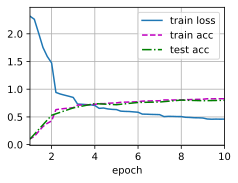

In [2]:
# 加载 Fashion-MNIST 数据集 (LeNet 使用)
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# GPU 评估准确率函数
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 训练函数 (train_ch6)
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# 开始训练 LeNet
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.330, train acc 0.878, test acc 0.880
1023.1 examples/sec on cuda:0


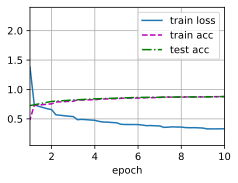

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义 AlexNet 模型
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

# 检查 AlexNet 每一层的输出形状 (测试代码)
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

# 训练 AlexNet
# 注意：这里 resize=224 是为了匹配 AlexNet 的输入需求
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())